# Background:
Visual styles are perceived subjectively, but useful information can be extracted from images that may lend insights into what makes them similar or dissimilar. This also implies that visual preferences and image recommendations may be inferred from existing user preferrence. What makes this task a challenge is the high diensional structure of the data matrix, and how less meaningful euclidean distance metrics become in high dimension. 

This notebook explores the use of ISOMAP and LocallyLinearEmbedding for dimensionality reduction and manifold learning of visual styles pertaining to street photography. Visual features are engineered to generate the data matrix, considering features such as histogram of colour hues, saturation and birdgtness, as well as image composition, texture, contrast. Over 300 images are sourced from the open web for this exercise.

### High level overview:
In this notebook, the following is performed:
1. Extraction of image features to form data matrix (334 samples x 1010 feature components).
2. Perform dimensionality reduction, comparing several methods. 
    1. ISOMAP Method 1: Find the radius in the manifold that ensures every node has at least 1 connected component. Optimize the number of components to mitigate the reconstruction error.
    2. ISOMAP Method 2: Optimize the number of neighbours and components to mitigate only reconstruction error.
    3. LLE: Optimize the number of neighbours and components to mitigate reconstruction error.
3. Find the most similar images on several test images using minimum geodesic distances for ISOMAP methods, and pairwise distance (Euclidean) for LLE.

Note: 
1. ISOMAP Method 1 and METHOD 2 are expected to generate tradeoffs between sparsity (reducing complexity and computation times in real world application) and the reconstruction error. Although sparsity is desired, the embedding can become inaccurate by omitting meaningful connections. Hence to compensate, the number of components are tuned to mitigate reconstruction error (METHOD 1). In METHOD 2, both the number of neighbours and components are tuned, giving more flexibility to the number of connections while reducing the dimension of the manifold to a geater degree than in METHOD 1. 
2. It is known that reconstruction error alone (using the pairwise distance metric) can be misleading as metric, given the geodesic distance in the manifold is more valuable. This is a limitation of the implementation that is actively being explored.
3. A/B testing is generally needed to determine preferred model, but this notebook is useful for visual inspection, giving similar images to several samples.

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from skimage import data, exposure
from skimage.feature import local_binary_pattern
from skimage.transform import rotate
import random
from collections import Counter
from sklearn.mixture import BayesianGaussianMixture
from sklearn.manifold import Isomap, LocallyLinearEmbedding
from sklearn.metrics import pairwise_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
import time

The functions here describe the features to be extracted from each image.

In [2]:
folder = '/Users/brintharaj/Dropbox/Mac/Desktop/Images/Street Photography'

def load_files_from_folder(folder,training_size):
    file_list = []
    file_list_train,file_list_test = [],[]
    imagefiles_dict = {'train':[],'test':[]}
    for filename in os.listdir(folder):
        file_list.append(filename)
    num_files = len(file_list)
    for x in range(num_files):
        if file_list[x] != '.DS_Store':
            img = plt.imread(os.path.join(folder,file_list[x]))
            if x <= int(training_size*num_files):
                imagefiles_dict['train'].append(img)
            else:
                imagefiles_dict['test'].append(img)
    return imagefiles_dict

def imshow_image(data):
    data = data.astype(dtype='uint8')
    graphic = Image.fromarray(data, 'RGB')
    plt.figure(figsize=(6,4))
    plt.imshow(np.asarray(graphic))
    plt.show()
    
def define_feature(feature_namelist,feature_lengthlist):
    col_list = []
    for f in range(len(feature_namelist)):
        name = feature_namelist[f]
        feature_length = feature_lengthlist[f]
        if feature_length > 1:
            for x in range(feature_length):
                update_name = name + str(x)
                col_list.append(update_name)
        else:
            col_list.append(name)
    
    return col_list

### Function to obtain HSV histogram of the image
def calc_hist(image):
    if len(image.shape) == 2:
        gray_image = image.copy()
        hue = cv2.calcHist([gray_image], [0], None, [256], [0, 256])
        sat = np.array([255]*256)
        sat = sat.reshape((sat.shape[0],1))
        val = hue.copy()
        hist = hue.flatten().tolist() + sat.flatten().tolist() + val.flatten().tolist()
        bw = 1
    else:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        x_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hue = cv2.calcHist([x_hsv], [0], None, [256], [0, 256])
        sat = cv2.calcHist([x_hsv], [1], None, [256], [0, 256])
        val = cv2.calcHist([x_hsv], [2], None, [256], [0, 256])
        hist = hue.flatten().tolist() + sat.flatten().tolist() + val.flatten().tolist()
        bw = 0
    return hist,bw

### Function to obtain texture and lighting features: Contrast, Energy and Correlation
def glcm_func(image):
    patch_size = 21
    distances1 = [1,2,5,10]
    angles1 = [0]
    angles2 = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    
    min_size = min(image.shape[0],image.shape[1])
    max_size = max(image.shape[0],image.shape[1])
    
    max_distance = min_size//2
    mid_distance = min_size//5
    near_distance = min_size//10
    distances2 = [1,2,3,5,10,near_distance,mid_distance,max_distance]

    small_step = min_size//4
    big_step = max_size//5
    small_list = [small_step,small_step*2,small_step*3]
    big_list = [big_step,big_step*2,big_step*3,big_step*4]
    if image.shape[1] > image.shape[0]:
        patches = [(small_list[0],big_list[0]),(small_list[1],big_list[0]),(small_list[2],big_list[0]),
                    (small_list[0],big_list[1]),(small_list[1],big_list[1]),(small_list[2],big_list[1]),
                    (small_list[0],big_list[2]),(small_list[1],big_list[2]),(small_list[2],big_list[2]),
                    (small_list[0],big_list[3]),(small_list[1],big_list[3]),(small_list[2],big_list[3])]
    else:
        patches = [(big_list[0],small_list[0]),(big_list[1],small_list[0]),(big_list[2],small_list[0]),(big_list[3],small_list[0]),
                    (big_list[0],small_list[1]),(big_list[1],small_list[1]),(big_list[2],small_list[1]),(big_list[3],small_list[1]),
                    (big_list[0],small_list[2]),(big_list[1],small_list[2]),(big_list[2],small_list[2]),(big_list[3],small_list[2])]
    
    contrast_list, energy_list,correlation_list = [],[],[]
    for p in patches:
        pic = image[p[0]:p[0]+patch_size,p[1]:p[1]+patch_size]
        glcm = graycomatrix(pic, distances=distances1, angles=angles1, levels=256,symmetric=True,normed=True)
        con = graycoprops(glcm, 'contrast').flatten().tolist()
        ene = graycoprops(glcm, 'energy').flatten().tolist()
        cor = graycoprops(glcm, 'correlation').flatten().tolist()
        for h in range(len(con)):
            contrast_list.append(con[h])
            energy_list.append(ene[h])
            correlation_list.append(cor[h])
      
    glcm = graycomatrix(image, distances=distances2, angles=angles2, levels=256,symmetric=True,normed=True)
    con = graycoprops(glcm, 'contrast').flatten().tolist()
    ene = graycoprops(glcm, 'energy').flatten().tolist()
    cor = graycoprops(glcm, 'correlation').flatten().tolist()
            
    contrast_list += con
    energy_list += ene
    correlation_list += cor
        
    return contrast_list,energy_list,correlation_list

### Obtain compositional element: Negative Space
def calculate_negative_space(image):
    _, thresh = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY_INV)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    largest_contour_area = cv2.contourArea(largest_contour)
    total_area = image.shape[0] * image.shape[1]
    negative_space_area = total_area - largest_contour_area
    return negative_space_area

Load the images, generate the data matrix and standardize it.

In [3]:
image_dict = load_files_from_folder(folder,1)
num_images = len(image_dict['train'])

feature_namelist = ['Histogram','Contrast','Energy','Correlation','B&W','Negative Space']
feature_lengthlist = [768,80,80,80,1,1]
col_list = define_feature(feature_namelist,feature_lengthlist)
df_main = pd.DataFrame(columns=col_list)

for i in ['train']:
    for im in image_dict[i]:
        m,n = im.shape[0],im.shape[1]
        if len(im.shape) == 2:
            gray_im = im.copy()
        else:
            gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) 
        img_hist,b_w = calc_hist(im)
        edges = cv2.Canny(gray_im,100,200)
        neg_space = calculate_negative_space(edges)
        contrast,energy,correlation = glcm_func(gray_im)
        feature_list = img_hist + contrast + energy + correlation + [b_w] + [neg_space]
        df_main.loc[len(df_main.index)] = feature_list
        
scaler = StandardScaler()
xdata_scaled = scaler.fit_transform(df_main)   

Note on ISOMAP tuning Method 1: Tuning of the epsilon (radius) threshold to build the Adjacency matrix was in consideration of ensuring every node had at
least one connected component, and there were no infinity values in the resulting Distance matrix. Otherwise, the
epsilon threshold is increased until the two conditions as stated are satisfied

Running Hyperparameter Tuning for ISOMAP Method 1
Tuning epsilon 

Epsilon (radius) found to ensure no disconnected nodes: 116


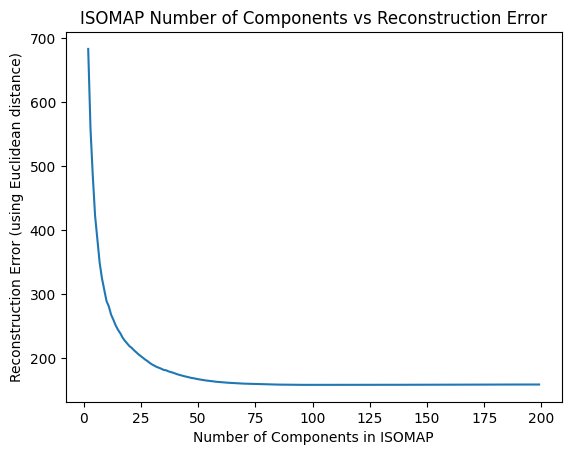

Optimal number of components: 110 in ISOMAP


In [4]:
##### Method 1: ISOMAP, with every node having at least 1 connection and minimum number of components 
##### to mitigate reconstruction error in Euclidean space
start = time.time()
print("Running Hyperparameter Tuning for ISOMAP Method 1")
epsilon = 1
matrix_A = np.zeros((num_images,num_images))
flag = True

##### Tuning epsilon to get at least 1 connected component
print(f"Tuning epsilon \n")
while flag == True:
    flag = False
    epsilon += 1
    for i in range(num_images):
        for j in range(num_images):
            vec = np.subtract(xdata_scaled[i,:],xdata_scaled[j,:])
            two_norm_distance = np.linalg.norm(vec)
            if two_norm_distance <= epsilon:
                matrix_A[i,j] = two_norm_distance
            else:
                matrix_A[i,j] = 0.
        if np.all(matrix_A[i,:] == 0):
            flag = True
            break
    matrix_A_sparse = csr_matrix(matrix_A)
    matrix_D = shortest_path(csgraph=matrix_A_sparse, method='FW',directed=False, return_predecessors=False)
    #### Ensure no disconnected nodes
    if np.inf in matrix_D:
        flag = True
        
print(f"Epsilon (radius) found to ensure no disconnected nodes: {epsilon}")

distances_original = pairwise_distances(xdata_scaled)
err_list = []
for nc in range(2,200):
    imap = Isomap(radius=epsilon,n_neighbors=None,n_components=nc)
    xdata_transformed_imap = imap.fit_transform(xdata_scaled)
    #xdata_transformed_imap = tune_isomap(matrix_D,nc)
    distances_reduced = pairwise_distances(xdata_transformed_imap)
    err = np.mean((distances_original - distances_reduced)**2)
    err_list.append(err)
    if nc == 2:
        min_err = err
        best_nc = nc
    else:
        if err < min_err:
            min_err = err
            best_nc = nc
plt.plot([i for i in range(2,200)],err_list)
plt.ylabel("Reconstruction Error (using Euclidean distance)")
plt.xlabel("Number of Components in ISOMAP")
plt.title("ISOMAP Number of Components vs Reconstruction Error")
plt.show()

print(f"Optimal number of components: {best_nc} in ISOMAP")
imap1 = Isomap(radius=epsilon,n_neighbors=None,n_components=best_nc)
xdata_transformed_imap1 = imap1.fit_transform(xdata_scaled)   
end = time.time()
time_taken1 = end - start

Running Hyperparameter Tuning for ISOMAP Method 2


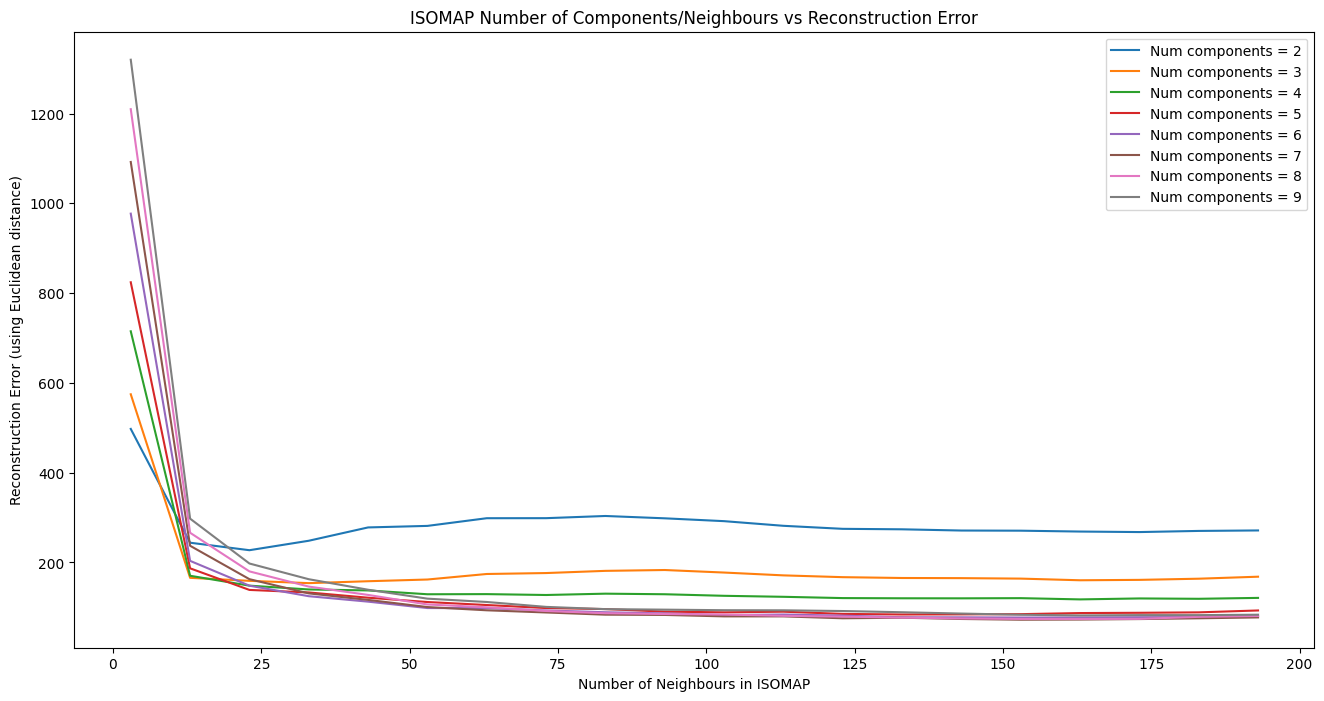

Optimal number of components: 7 and neighbours: 153 in ISOMAP


In [5]:
##### Method 2: ISOMAP, with minimum number of neighbours and components to mitigate reconstruction error in Euclidean space
start = time.time()
plt.figure(figsize=(16,8))
print("Running Hyperparameter Tuning for ISOMAP Method 2")
distances_original = pairwise_distances(xdata_scaled)
for nc in range(2,10):
    err_list = []
    for nn in range(3,200,10):
        imap = Isomap(n_neighbors=nn,n_components=nc)
        xdata_transformed_imap = imap.fit_transform(xdata_scaled)
        distances_reduced = pairwise_distances(xdata_transformed_imap)
        err = np.mean((distances_original - distances_reduced)**2)
        err_list.append(err)
        if nc == 2 and nn == 3:
            min_err = err
            best_nc = nc
            best_nn = nn
        else:
            if err < min_err:
                min_err = err
                best_nc = nc
                best_nn = nn
    plt.plot([i for i in range(3,200,10)],err_list,label=f"Num components = {nc}")
plt.ylabel("Reconstruction Error (using Euclidean distance)")
plt.xlabel("Number of Neighbours in ISOMAP")
plt.title("ISOMAP Number of Components/Neighbours vs Reconstruction Error")
plt.legend()
plt.show()

print(f"Optimal number of components: {best_nc} and neighbours: {best_nn} in ISOMAP")
imap2 = Isomap(n_neighbors=best_nn,n_components=best_nc)
xdata_transformed_imap2 = imap2.fit_transform(xdata_scaled) 
end = time.time()
time_taken2 = end - start

Time taken for ISOMAP Method 1: 73.09915614128113 vs Method 2: 15.529139995574951 



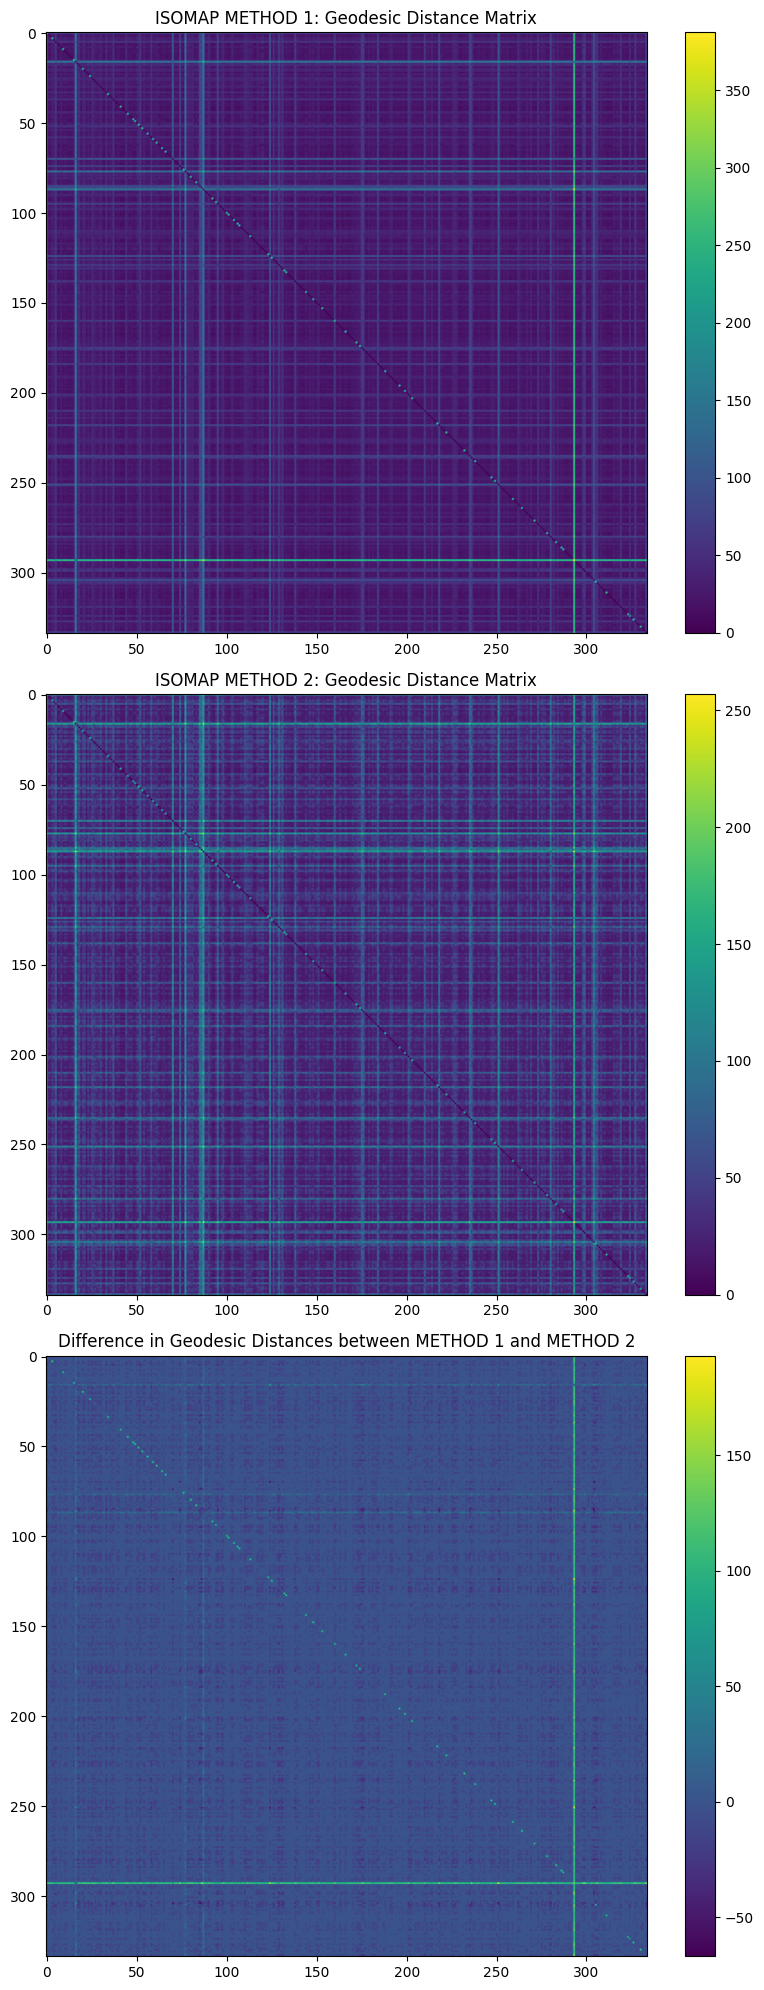

In [34]:
print(f"Time taken for ISOMAP Method 1: {time_taken1} vs Method 2: {time_taken2} \n")

fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(8,20))
im = ax[0].imshow(imap1.dist_matrix_)
ax[0].set_title("ISOMAP METHOD 1: Geodesic Distance Matrix")
plt.colorbar(im)
im = ax[1].imshow(imap2.dist_matrix_)
ax[1].set_title("ISOMAP METHOD 2: Geodesic Distance Matrix")
plt.colorbar(im)
im = ax[2].imshow(imap1.dist_matrix_ - imap2.dist_matrix_)
ax[2].set_title("Difference in Geodesic Distances between METHOD 1 and METHOD 2")
plt.colorbar(im)
plt.tight_layout()
plt.show()

It can be observed the similarity for both methods 1 and 2 in the geodesic distance matrix. Method 1 values lie in a greater scale, expected given the sparsity of the adjacency matrix by design and the higher dimensionality determined during the tuning process. Notable, the difference is showing in what looks to be a single sample having notable difference when using both methods. 

Running Hyperparameter Tuning for LLE


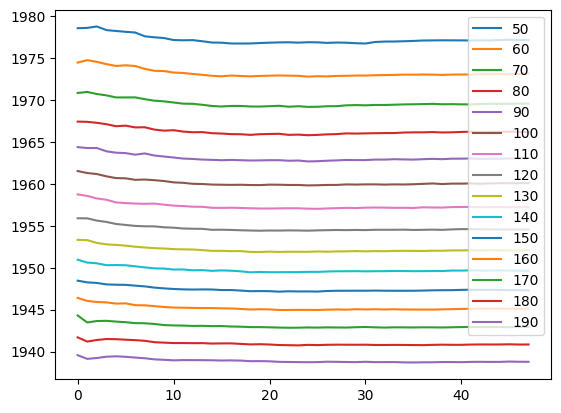

Optimal number of components: 190 and neighbours: 37 in LLE


In [7]:
#### This section is for LLE
print("Running Hyperparameter Tuning for LLE")
distances_original = pairwise_distances(xdata_scaled)
for nc in range(50,200,10):
    err_list = []
    for nn in range(2,50):
        lle = LocallyLinearEmbedding(n_neighbors=nn,n_components=nc)
        xdata_transformed_lle = lle.fit_transform(xdata_scaled)
        distances_reduced = pairwise_distances(xdata_transformed_lle)
        err = np.mean((distances_original - distances_reduced)**2)
        err_list.append(err)
        if nc == 50 and nn == 2:
            min_err = err
            best_nc = nc
            best_nn = nn
        else:
            if err < min_err:
                min_err = err
                best_nc = nc
                best_nn = nn
    plt.plot(err_list,label=nc)
    plt.legend()
plt.show()

print(f"Optimal number of components: {best_nc} and neighbours: {best_nn} in LLE")
lle = LocallyLinearEmbedding(n_neighbors=best_nn,n_components=best_nc)
xdata_transformed_lle = lle.fit_transform(xdata_scaled)

Note that the LLE tuning does not converge in finding an optimal number of components within the test limit, 
indicating its limitations, or that a different metric should be considered with LLE.

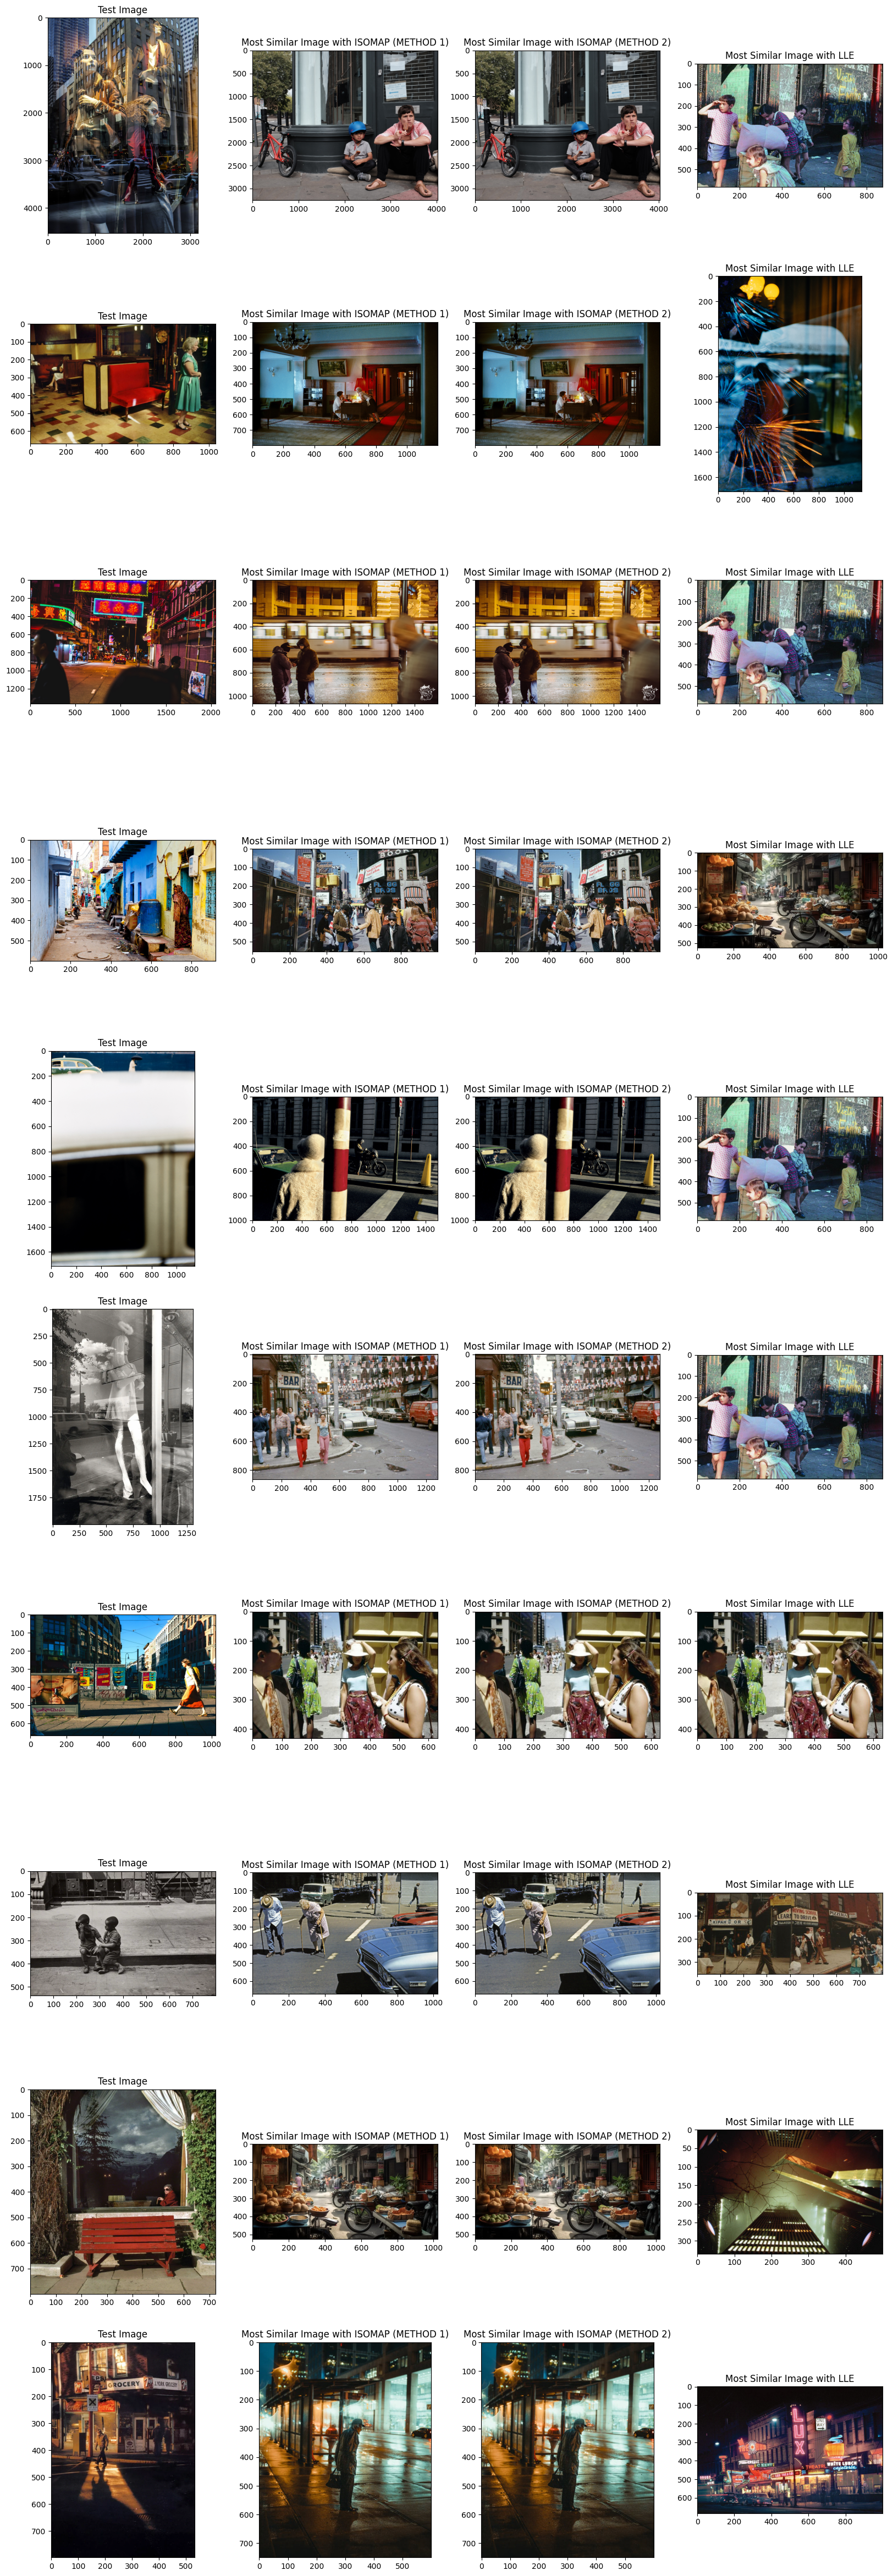

In [39]:
### Visual inspection of 10 random test images
random_images_idx = random.sample(df_main.index.to_list(),k=10)
fig,ax = plt.subplots(nrows=10,ncols=4,figsize=(20,60))
r,c = 0,0
for y in random_images_idx:
    ### Find closest image stylistically using geodesic distance in the manifold for ISOMAP (METHOD1)
    distances_geodesic1 = imap1.dist_matrix_[y,:]
    distances_geodesic1[y] = distances_geodesic1[np.argmax(distances_geodesic1)]
    rec_idx_imap1 = np.argmin(distances_geodesic1)
    
    ### Find closest image stylistically using geodesic distance in the manifold for ISOMAP (METHOD2)
    distances_geodesic2 = imap2.dist_matrix_[y,:]
    distances_geodesic2[y] = distances_geodesic2[np.argmax(distances_geodesic2)]
    rec_idx_imap2 = np.argmin(distances_geodesic2)
    
    ### Find closest image stylistically using euclidean distance in the embedding for LLE
    distances_linear = pairwise_distances(xdata_transformed_lle[y,:].reshape(1, -1),xdata_transformed_lle[:,:])
    distances_linear = distances_linear.flatten()
    distances_linear[y] = distances_linear[np.argmax(distances_linear)]
    rec_idx_lle = np.argmin(distances_linear)
    
    if len(image_dict['train'][y]) == 3:
        ax[r][c].imshow(image_dict['train'][y])
    else:
        ax[r][c].imshow(image_dict['train'][y],cmap='gray')
    if len(image_dict['train'][rec_idx_imap1]) == 3:
        ax[r][c+1].imshow(image_dict['train'][rec_idx_imap1])
    else:
        ax[r][c+1].imshow(image_dict['train'][rec_idx_imap1],cmap='gray')
    if len(image_dict['train'][rec_idx_imap2]) == 3:
        ax[r][c+2].imshow(image_dict['train'][rec_idx_imap2])
    else:
        ax[r][c+2].imshow(image_dict['train'][rec_idx_imap2],cmap='gray')
    if len(image_dict['train'][rec_idx_lle]) == 3:
        ax[r][c+3].imshow(image_dict['train'][rec_idx_lle])
    else:
        ax[r][c+3].imshow(image_dict['train'][rec_idx_lle],cmap='gray')    
    ax[r][c].set_title("Test Image")
    ax[r][c+1].set_title("Most Similar Image with ISOMAP (METHOD 1)")
    ax[r][c+2].set_title("Most Similar Image with ISOMAP (METHOD 2)")
    ax[r][c+3].set_title("Most Similar Image with LLE")
    r += 1
plt.show()

## Summary
The results indicate ISOMAP Method 1 (radius: 116 and number of components: 110) gives exact same recommendations as ISOMAP Method 2 (number of neighbours: 153, number of components: 7). METHOD 2 tuning process is observed to be faster (expected to vary in reality, depending on parameter grid chosen). This implies METHOD 2, with the lower dimension and denser adjacency matrix, may be preffered if the computational gains can be scaled in volume, to real applications for visual preference manifold learing. 

Comparing ISOMAP with LLE by visual inspection of the recommended images, it does appear ISOMAP performs better (according to what I perceive as stylistically similar in accordance to the features defined and engineered from the images). However, given subjectivity of visual preferrences, large scale A/B testing will be required to experiment and develop a generalized model that can cater to a variety of stylistic preferrences and subjectivity in image analysis (not just mine).